# * Prepaid Performance *

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
''' Config '''

config = configparser.ConfigParser()
config.read('../../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']
v_product = 'Prepaid'

In [3]:
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
prepaid_rev_cd_list = ['B1R000100CORP', 'B1R000101CORP', 'B1R000102CORP'] # 'Prepaid Revenue', 'Prepaid New Revenue', 'Prepaid Existing Revenue'
prepaid_dtac_rev_cd_list = ['DB1R000100', 'DB1R000101', 'DB1R000102'] # 'Prepaid Revenue : DTAC', 'Prepaid New Revenue : DTAC', 'Prepaid Existing Revenue : DTAC'
prepaid_tmh_rev_cd_list = ['TB1R000100CORP', 'TB1R000101CORP', 'TB1R000102CORP'] # 'Prepaid Revenue : TMH', 'Prepaid New Revenue : TMH', 'Prepaid Existing Revenue : TMH'
prepaid_all_rev_cd_list = prepaid_rev_cd_list + prepaid_dtac_rev_cd_list + prepaid_tmh_rev_cd_list
# prepaid_total_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']

In [4]:
df.shape

(170729, 24)

In [5]:
''' Find Metric '''

# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND'])\
    .agg({'ACTUAL_SNAP': 'sum', 'ACTUAL_AGG': 'sum', 'TARGET_SNAP': 'sum', 'TARGET_AGG': 'sum', 'BASELINE_SNAP':'sum', 'BASELINE_AGG':'sum', 'TM_KEY_DAY':'max'}).reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 
                     'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'TM_KEY_DAY']]
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric = df_metric.rename(columns={'TM_KEY_DAY':'MAX_DAY'})
df_metric['ACTUAL_SNAP'] = df_metric['ACTUAL_SNAP'] / 1000000
df_metric['ACTUAL_AGG'] = df_metric['ACTUAL_AGG'] / 1000000
df_metric['TARGET_SNAP'] = df_metric['TARGET_SNAP'] / 1000000
df_metric['TARGET_AGG'] = df_metric['TARGET_AGG'] / 1000000
df_metric['BASELINE_SNAP'] = df_metric['BASELINE_SNAP'] / 1000000
df_metric['BASELINE_AGG'] = df_metric['BASELINE_AGG'] / 1000000
# df_metric

''' Filters '''
# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Prepaid"]#.reset_index()
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
df_tmp = df_metric[df_metric['METRIC_CD'].isin(prepaid_all_rev_cd_list)]
df_tmp = df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD']).reset_index()

# df_tmp.to_excel('Prepaid_Metric.xlsx', index=False)
df_tmp

,index,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,GRY_IND,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,BASELINE_SNAP,BASELINE_AGG,MAX_DAY
0,44,Revenue,Revenue,ALL,Prepaid,B1R000100CORP,Prepaid Revenue,S,GYR,36653.465422,574798.900061,35947.821208,563372.521702,0.0,0.0,20231224
1,46,Revenue,Revenue,ALL,Prepaid,B1R000101CORP,Prepaid New Revenue,S,GYR,11135.353773,172428.025677,4855.744473,75226.163294,0.0,0.0,20231224
2,48,Revenue,Revenue,ALL,Prepaid,B1R000102CORP,Prepaid Existing Revenue,S,GYR,25518.111649,402370.874384,15342.075226,239099.684467,0.0,0.0,20231224
3,59,Revenue,Revenue,DTAC,Prepaid,DB1R000100,Prepaid Revenue : DTAC,S,GYR,15848.454468,249133.785271,15750.001509,249046.673941,0.0,0.0,20231224
4,60,Revenue,Revenue,DTAC,Prepaid,DB1R000101,Prepaid New Revenue : DTAC,S,GYR,5660.802186,87752.651428,0.000000,0.000000,0.0,0.0,20231224
5,61,Revenue,Revenue,DTAC,Prepaid,DB1R000102,Prepaid Existing Revenue : DTAC,S,GYR,10187.652282,161381.133843,0.000000,0.000000,0.0,0.0,20231224
6,74,Revenue,Revenue,TRUE,Prepaid,TB1R000100CORP,Prepaid Revenue : TMH,S,GYR,20805.010954,325665.114790,20061.846498,313985.914758,0.0,0.0,20231224
7,76,Revenue,Revenue,TRUE,Prepaid,TB1R000101CORP,Prepaid New Revenue : TMH,S,GYR,5474.551587,84675.374248,4814.035897,75121.891853,0.0,0.0,20231224
8,78,Revenue,Revenue,TRUE,Prepaid,TB1R000102CORP,Prepaid Existing Revenue : TMH,S,GYR,15330.459367,240989.740541,15247.810601,238864.022905,0.0,0.0,20231224


## Data Preporation

In [6]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [7]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202310] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230617] # DAY filter
df = df[df['METRIC_CD'].isin(prepaid_all_rev_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG', 'BASELINE_SNAP':'BL_SNAP', 'BASELINE_AGG':'BL_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BL_SNAP,BL_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
105544,20231222,2023051,202312,20234,2023,Revenue,Revenue,TRUE,Prepaid,TB1R000100CORP,...,NaN,1.565773e+09,NaN,1.427719e+09,NaN,0.0,2023-12-25 07:39:15,December,51,22
105545,20231223,2023051,202312,20234,2023,Revenue,Revenue,TRUE,Prepaid,TB1R000100CORP,...,NaN,1.565773e+09,NaN,1.427719e+09,NaN,0.0,2023-12-25 07:39:15,December,51,23
105546,20231224,2023051,202312,20234,2023,Revenue,Revenue,TRUE,Prepaid,TB1R000100CORP,...,NaN,1.565773e+09,NaN,1.427719e+09,NaN,0.0,2023-12-25 07:39:15,December,51,24


In [8]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

In [9]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [10]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 
            'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG', 'BL_SNAP', 'BL_AGG']
df_day = df[cols_agg].reset_index()

''' Aggregation '''
df_day['ACT'] = np.where(df_day['AGG_TYPE']=='N', df_day['ACT_AGG'], df_day['ACT_SNAP'])
df_day['TGT'] = np.where(df_day['AGG_TYPE']=='N', df_day['TGT_AGG'], df_day['TGT_SNAP'])
# df_day['%ACHV'] = df_day['ACT'] / df_day['TGT']
df_day['%ACHV'] = np.where(df_day['METRIC_NAME'].str.contains("Churn"), -((df_day['ACT']/df_day['TGT'])-1), df_day['ACT']/df_day['TGT']) 
df_day['GAP'] = df_day['ACT'] - df_day['TGT']
df_day['LAST_ACT'] = df_day.groupby('METRIC_CD')['ACT'].shift()
df_day['DIFF'] = df_day['ACT'] - df_day['LAST_ACT']
df_day['%DOD'] = (df_day['ACT'] / df_day['LAST_ACT']) - 1

# df_day.to_excel('df_rev_mth.xlsx', index=False)
df_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,TGT_AGG,BL_SNAP,BL_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
2688,105544,TB1R000100CORP,Prepaid Revenue : TMH,20231222,2023051,202312,20234,2023,December,22,...,1.427719e+09,NaN,0.0,NaN,NaN,NaN,NaN,6.889306e+07,NaN,NaN
2689,105545,TB1R000100CORP,Prepaid Revenue : TMH,20231223,2023051,202312,20234,2023,December,23,...,1.427719e+09,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2690,105546,TB1R000100CORP,Prepaid Revenue : TMH,20231224,2023051,202312,20234,2023,December,24,...,1.427719e+09,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
''' Fix Columns Dict '''

cols_dict = {'Prepaid Existing Revenue': 'EXIST', 'Prepaid Existing Revenue : DTAC': 'EXIST_DTAC', 'Prepaid Existing Revenue : TMH': 'EXIST_TMH', 
             'Prepaid New Revenue': 'NEW', 'Prepaid New Revenue : DTAC': 'NEW_DTAC', 'Prepaid New Revenue : TMH': 'NEW_TMH', 
             'Prepaid Revenue': 'TOTAL', 'Prepaid Revenue : DTAC': 'TOTAL_DTAC', 'Prepaid Revenue : TMH': 'TOTAL_TMH'}

In [12]:
''' Pivot by KPIS '''

df_day_agg = df_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR  MTH_DESC  \
METRIC_NAME                                                                  
296           20231222   2023051     202312      20234      2023  December   
297           20231223   2023051     202312      20234      2023  December   
298           20231224   2023051     202312      20234      2023  December   

            DAY_LABEL           ACT                          ...      DIFF  \
METRIC_NAME                   EXIST    EXIST_DTAC EXIST_TMH  ... TOTAL_TMH   
296                22  2.792447e+07  2.792447e+07       NaN  ...       NaN   
297                23  2.708294e+07  2.708294e+07       NaN  ...       NaN   
298                24           NaN           NaN       NaN  ...       NaN   

                 %DOD                                                   \
METRIC_NAME     EXIST EXIST_DTAC EXIST_TMH       NEW  NEW_DTAC NEW_TMH   
296         -0.612934  -0.007831       NaN -0.474286  0.008219     NaN   
297         -0.030136  -0.030136       NaN -0.010493 -0.010493     NaN   
298               NaN        NaN       NaN       NaN       NaN     NaN   

                                            
METRIC_NAME     TOTAL TOTAL_DTAC TOTAL_TMH  
296         -0.554848   0.000046       NaN  
297         -0.020417  -0.020417       NaN  
298               NaN        NaN       NaN  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [13]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
# df_yr['%ACHV'] = df_yr['ACT'] / df_yr['TGT']
df_yr['%ACHV'] = np.where(df_yr['METRIC_NAME'].str.contains("Churn"), -((df_yr['ACT']/df_yr['TGT'])-1), df_yr['ACT']/df_yr['TGT']) 
df_yr['GAP'] = df_yr['ACT'] - df_yr['TGT']
df_yr['LAST_ACT'] = df_yr.groupby('METRIC_CD')['ACT'].shift()
df_yr['DIFF'] = df_yr['ACT'] - df_yr['LAST_ACT']
df_yr['%YOY'] = (df_yr['ACT'] / df_yr['LAST_ACT']) - 1

# df_yr.to_excel('df_yr.xlsx')
df_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100CORP,Prepaid Revenue,2023,S,3.665347e+10,3.594782e+10,1.019630,7.056442e+08,NaN,NaN,NaN
1,B1R000101CORP,Prepaid New Revenue,2023,S,1.113535e+10,4.855744e+09,2.293233,6.279609e+09,NaN,NaN,NaN
2,B1R000102CORP,Prepaid Existing Revenue,2023,S,2.551811e+10,1.534208e+10,1.663276,1.017604e+10,NaN,NaN,NaN
3,DB1R000100,Prepaid Revenue : DTAC,2023,S,1.584845e+10,1.575000e+10,1.006251,9.845296e+07,NaN,NaN,NaN
4,DB1R000101,Prepaid New Revenue : DTAC,2023,S,5.660802e+09,0.000000e+00,inf,5.660802e+09,NaN,NaN,NaN
5,DB1R000102,Prepaid Existing Revenue : DTAC,2023,S,1.018765e+10,0.000000e+00,inf,1.018765e+10,NaN,NaN,NaN
6,TB1R000100CORP,Prepaid Revenue : TMH,2023,S,2.080501e+10,2.006185e+10,1.037044,7.431645e+08,NaN,NaN,NaN
7,TB1R000101CORP,Prepaid New Revenue : TMH,2023,S,5.474552e+09,4.814036e+09,1.137206,6.605157e+08,NaN,NaN,NaN
8,TB1R000102CORP,Prepaid Existing Revenue : TMH,2023,S,1.533046e+10,1.524781e+10,1.005420,8.264877e+07,NaN,NaN,NaN


In [14]:
''' Pivot by KPIS '''

df_yr_agg = df_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_yr_agg.tail(3)

TM_KEY_YR           ACT                                            \
METRIC_NAME                   EXIST    EXIST_DTAC     EXIST_TMH           NEW   
0                2023  2.551811e+10  1.018765e+10  1.533046e+10  1.113535e+10   

                                                                     \
METRIC_NAME      NEW_DTAC       NEW_TMH         TOTAL    TOTAL_DTAC   
0            5.660802e+09  5.474552e+09  3.665347e+10  1.584845e+10   

                           ...      DIFF  %YOY                           \
METRIC_NAME     TOTAL_TMH  ... TOTAL_TMH EXIST EXIST_DTAC EXIST_TMH NEW   
0            2.080501e+10  ...       NaN   NaN        NaN       NaN NaN   

                                                         
METRIC_NAME NEW_DTAC NEW_TMH TOTAL TOTAL_DTAC TOTAL_TMH  
0                NaN     NaN   NaN        NaN       NaN  

[1 rows x 64 columns]

In [15]:
''' YTD Values '''

df_last_yr = df_day_agg[df_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT', 'TGT']]
day_cnt_curr_yr = len(df_day_agg[(df_day_agg['TM_KEY_YR']==curr_yr) & (df_day_agg['ACT']['TOTAL']>0)]['TM_KEY_DAY'].unique())

ytd_last_act = (df_last_yr['ACT']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_59044\345330331.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [16]:
''' Year Chart Values '''

x_yr = df_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Values '''
y_yr_act = df_yr_agg['ACT']['TOTAL']
y_yr_act_dtac = df_yr_agg['ACT']['TOTAL_DTAC']
y_yr_act_tmh = df_yr_agg['ACT']['TOTAL_TMH']
y_yr_tgt = df_yr_agg['TGT']['TOTAL']
y_yr_tgt_dtac = df_yr_agg['TGT']['TOTAL_DTAC']
y_yr_tgt_tmh = df_yr_agg['TGT']['TOTAL_TMH']
y_yr_achv = df_yr_agg['%ACHV']['TOTAL']
y_yr_achv_dtac = df_yr_agg['%ACHV']['TOTAL_DTAC']
y_yr_achv_tmh = df_yr_agg['%ACHV']['TOTAL_TMH']
y_yr_gap = df_yr_agg['GAP']['TOTAL']
y_yr_gap_dtac = df_yr_agg['GAP']['TOTAL_DTAC']
y_yr_gap_tmh = df_yr_agg['GAP']['TOTAL_TMH']
y_yr_diff = df_yr_agg['DIFF']['TOTAL']
y_yr_diff_dtac = df_yr_agg['DIFF']['TOTAL_DTAC']
y_yr_diff_tmh = df_yr_agg['DIFF']['TOTAL_TMH']
y_yr_last_act = df_yr_agg['LAST_ACT']['TOTAL']
y_yr_last_act_dtac = df_yr_agg['LAST_ACT']['TOTAL_DTAC']
y_yr_last_act_tmh = df_yr_agg['LAST_ACT']['TOTAL_TMH']
y_yr_yoy = df_yr_agg['%YOY']['TOTAL']
y_yr_yoy_dtac = df_yr_agg['%YOY']['TOTAL_DTAC']
y_yr_yoy_tmh = df_yr_agg['%YOY']['TOTAL_TMH']

''' NEW : Values '''
y_yr_act_new = df_yr_agg['ACT']['NEW']
y_yr_act_new_dtac = df_yr_agg['ACT']['NEW_DTAC']
y_yr_act_new_tmh = df_yr_agg['ACT']['NEW_TMH']
y_yr_tgt_new = df_yr_agg['TGT']['NEW']
y_yr_tgt_new_dtac = df_yr_agg['TGT']['NEW_DTAC']
y_yr_tgt_new_tmh = df_yr_agg['TGT']['NEW_TMH']
y_yr_achv_new = df_yr_agg['%ACHV']['NEW']
y_yr_achv_new_dtac = df_yr_agg['%ACHV']['NEW_DTAC']
y_yr_achv_new_tmh = df_yr_agg['%ACHV']['NEW_TMH']
y_yr_gap_new = df_yr_agg['GAP']['NEW']
y_yr_gap_new_dtac = df_yr_agg['GAP']['NEW_DTAC']
y_yr_gap_new_tmh = df_yr_agg['GAP']['NEW_TMH']
y_yr_diff_new = df_yr_agg['DIFF']['NEW']
y_yr_diff_new_dtac = df_yr_agg['DIFF']['NEW_DTAC']
y_yr_diff_new_tmh = df_yr_agg['DIFF']['NEW_TMH']
y_yr_last_act_new = df_yr_agg['LAST_ACT']['NEW']
y_yr_last_act_new_dtac = df_yr_agg['LAST_ACT']['NEW_DTAC']
y_yr_last_act_new_tmh = df_yr_agg['LAST_ACT']['NEW_TMH']
y_yr_yoy_new = df_yr_agg['%YOY']['NEW']
y_yr_yoy_new_dtac = df_yr_agg['%YOY']['NEW_DTAC']
y_yr_yoy_new_tmh = df_yr_agg['%YOY']['NEW_TMH']

''' EXIST : Values '''
y_yr_act_exist = df_yr_agg['ACT']['EXIST']
y_yr_act_exist_dtac = df_yr_agg['ACT']['EXIST_DTAC']
y_yr_act_exist_tmh = df_yr_agg['ACT']['EXIST_TMH']
y_yr_tgt_exist = df_yr_agg['TGT']['EXIST']
y_yr_tgt_exist_dtac = df_yr_agg['TGT']['EXIST_DTAC']
y_yr_tgt_exist_tmh = df_yr_agg['TGT']['EXIST_TMH']
y_yr_achv_exist = df_yr_agg['%ACHV']['EXIST']
y_yr_achv_exist_dtac = df_yr_agg['%ACHV']['EXIST_DTAC']
y_yr_achv_exist_tmh = df_yr_agg['%ACHV']['EXIST_TMH']
y_yr_gap_exist = df_yr_agg['GAP']['EXIST']
y_yr_gap_exist_dtac = df_yr_agg['GAP']['EXIST_DTAC']
y_yr_gap_exist_tmh = df_yr_agg['GAP']['EXIST_TMH']
y_yr_diff_exist = df_yr_agg['DIFF']['EXIST']
y_yr_diff_exist_dtac = df_yr_agg['DIFF']['EXIST_DTAC']
y_yr_diff_exist_tmh = df_yr_agg['DIFF']['EXIST_TMH']
y_yr_last_act_exist = df_yr_agg['LAST_ACT']['EXIST']
y_yr_last_act_exist_dtac = df_yr_agg['LAST_ACT']['EXIST_DTAC']
y_yr_last_act_exist_tmh = df_yr_agg['LAST_ACT']['EXIST_TMH']
y_yr_yoy_exist = df_yr_agg['%YOY']['EXIST']
y_yr_yoy_exist_dtac = df_yr_agg['%YOY']['EXIST_DTAC']
y_yr_yoy_exist_tmh = df_yr_agg['%YOY']['EXIST_TMH']

### YR : Visualizations

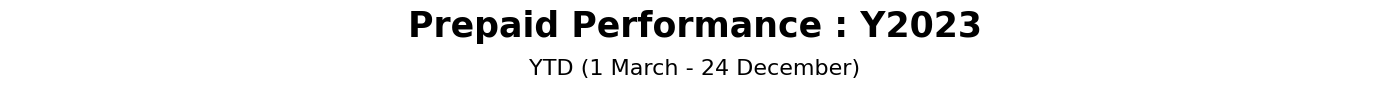

In [17]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

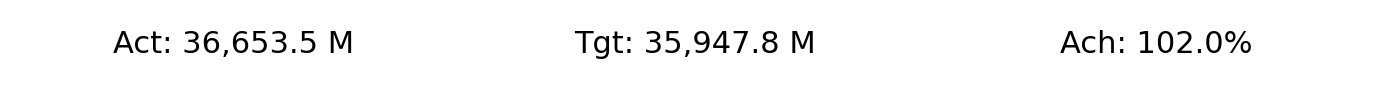

In [18]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(ytd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

fig.tight_layout()
plt.show()

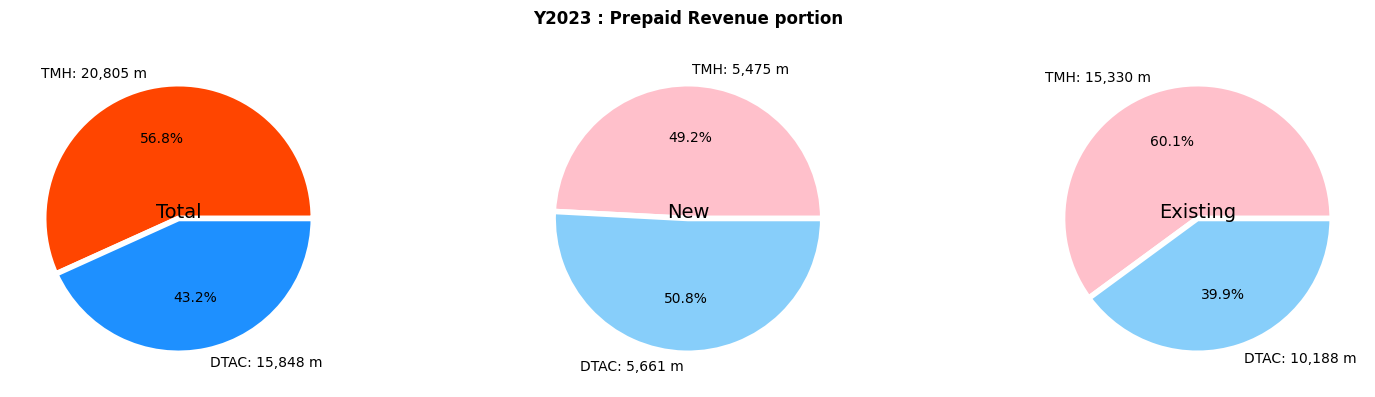

In [19]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(y_yr_act_tmh.sum()), unit_mb(y_yr_act_dtac.sum())])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'Total', ha='center', fontsize=14)

''' ax2 '''
y = np.array([unit_mb(y_yr_act_new_tmh.sum()), unit_mb(y_yr_act_new_dtac.sum())])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["pink", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'New', ha='center', fontsize=14)

''' ax3 '''
y = np.array([unit_mb(y_yr_act_exist_tmh.sum()), unit_mb(y_yr_act_exist_dtac.sum())])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["pink", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Existing', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [20]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_mth['%ACHV'] = np.where(df_mth['METRIC_NAME'].str.contains("Churn"), -((df_mth['ACT']/df_mth['TGT'])-1), df_mth['ACT']/df_mth['TGT']) 
df_mth['GAP'] = df_mth['ACT'] - df_mth['TGT']
df_mth['LAST_ACT'] = df_mth.groupby('METRIC_CD')['ACT'].shift()
df_mth['DIFF'] = df_mth['ACT'] - df_mth['LAST_ACT']
df_mth['%MOM'] = (df_mth['ACT'] / df_mth['LAST_ACT']) - 1

# df_mth.to_excel('df_mth.xlsx')
df_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
85,TB1R000102CORP,Prepaid Existing Revenue : TMH,202308,August,S,1.555806e+09,1.561333e+09,0.996460,-5.526780e+06,1.595988e+09,-4.018106e+07,-0.025176
86,TB1R000102CORP,Prepaid Existing Revenue : TMH,202309,September,S,1.479662e+09,1.514678e+09,0.976882,-3.501645e+07,1.555806e+09,-7.614496e+07,-0.048942
87,TB1R000102CORP,Prepaid Existing Revenue : TMH,202310,October,S,1.544661e+09,1.511960e+09,1.021628,3.270097e+07,1.479662e+09,6.499924e+07,0.043928
88,TB1R000102CORP,Prepaid Existing Revenue : TMH,202311,November,S,1.512673e+09,1.472922e+09,1.026987,3.975040e+07,1.544661e+09,-3.198807e+07,-0.020709
89,TB1R000102CORP,Prepaid Existing Revenue : TMH,202312,December,S,1.018507e+09,9.897786e+08,1.029025,2.872869e+07,1.512673e+09,-4.941654e+08,-0.326684


In [21]:
''' Pivot by KPIS '''

df_mth_agg = df_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_mth_agg.tail(3)

TM_KEY_MTH  MTH_DESC           ACT                              \
METRIC_NAME                              EXIST    EXIST_DTAC     EXIST_TMH   
7               202310   October  2.502676e+09  9.580150e+08  1.544661e+09   
8               202311  November  2.450832e+09  9.381595e+08  1.512673e+09   
9               202312  December  1.709879e+09  6.913713e+08  1.018507e+09   

                                                                     \
METRIC_NAME           NEW      NEW_DTAC       NEW_TMH         TOTAL   
7            1.378282e+09  6.810490e+08  6.972328e+08  3.880958e+09   
8            1.509837e+09  7.625682e+08  7.472688e+08  3.960669e+09   
9            1.178832e+09  6.315655e+08  5.472661e+08  2.888710e+09   

                           ...          DIFF      %MOM                       \
METRIC_NAME    TOTAL_DTAC  ...     TOTAL_TMH     EXIST EXIST_DTAC EXIST_TMH   
7            1.639064e+09  ...  1.383164e+08  0.024613  -0.005069  0.043928   
8            1.700728e+09  ...  1.804792e+07 -0.020715  -0.020726 -0.020709   
9            1.322937e+09  ... -6.941681e+08 -0.302327  -0.263056 -0.326684   

                                                                          
METRIC_NAME       NEW  NEW_DTAC   NEW_TMH     TOTAL TOTAL_DTAC TOTAL_TMH  
7            0.104793  0.092069  0.117511  0.051720   0.033114  0.065753  
8            0.095449  0.119696  0.071764  0.020539   0.037621  0.008050  
9           -0.219233 -0.171791 -0.267645 -0.270651  -0.222135 -0.307162  

[3 rows x 65 columns]

In [22]:
''' MTD Values '''

df_last_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT', 'TGT']]
day_cnt_curr_mth = len(df_day_agg[(df_day_agg['TM_KEY_MTH']==curr_mth) & (df_day_agg['ACT']['TOTAL']>0)]['TM_KEY_DAY'].unique())

mtd_last_act = (df_last_mth['ACT']['TOTAL'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [23]:
''' Month Chart Values '''

x_mth = df_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Values '''
y_mth_act = df_mth_agg['ACT']['TOTAL']
y_mth_act_dtac = df_mth_agg['ACT']['TOTAL_DTAC']
y_mth_act_tmh = df_mth_agg['ACT']['TOTAL_TMH']
y_mth_tgt = df_mth_agg['TGT']['TOTAL']
y_mth_tgt_dtac = df_mth_agg['TGT']['TOTAL_DTAC']
y_mth_tgt_tmh = df_mth_agg['TGT']['TOTAL_TMH']
y_mth_achv = df_mth_agg['%ACHV']['TOTAL']
y_mth_achv_dtac = df_mth_agg['%ACHV']['TOTAL_DTAC']
y_mth_achv_tmh = df_mth_agg['%ACHV']['TOTAL_TMH']
y_mth_gap = df_mth_agg['GAP']['TOTAL']
y_mth_gap_dtac = df_mth_agg['GAP']['TOTAL_DTAC']
y_mth_gap_tmh = df_mth_agg['GAP']['TOTAL_TMH']
y_mth_diff = df_mth_agg['DIFF']['TOTAL']
y_mth_diff_dtac = df_mth_agg['DIFF']['TOTAL_DTAC']
y_mth_diff_tmh = df_mth_agg['DIFF']['TOTAL_TMH']
y_mth_last_act = df_mth_agg['LAST_ACT']['TOTAL']
y_mth_last_act_dtac = df_mth_agg['LAST_ACT']['TOTAL_DTAC']
y_mth_last_act_tmh = df_mth_agg['LAST_ACT']['TOTAL_TMH']
y_mth_mom = df_mth_agg['%MOM']['TOTAL']
y_mth_mom_dtac = df_mth_agg['%MOM']['TOTAL_DTAC']
y_mth_mom_tmh = df_mth_agg['%MOM']['TOTAL_TMH']

''' NEW : Values '''
y_mth_act_new = df_mth_agg['ACT']['NEW']
y_mth_act_new_dtac = df_mth_agg['ACT']['NEW_DTAC']
y_mth_act_new_tmh = df_mth_agg['ACT']['NEW_TMH']
y_mth_tgt_new = df_mth_agg['TGT']['NEW']
y_mth_tgt_new_dtac = df_mth_agg['TGT']['NEW_DTAC']
y_mth_tgt_new_tmh = df_mth_agg['TGT']['NEW_TMH']
y_mth_achv_new = df_mth_agg['%ACHV']['NEW']
y_mth_achv_new_dtac = df_mth_agg['%ACHV']['NEW_DTAC']
y_mth_achv_new_tmh = df_mth_agg['%ACHV']['NEW_TMH']
y_mth_gap_new = df_mth_agg['GAP']['NEW']
y_mth_gap_new_dtac = df_mth_agg['GAP']['NEW_DTAC']
y_mth_gap_new_tmh = df_mth_agg['GAP']['NEW_TMH']
y_mth_diff_new = df_mth_agg['DIFF']['NEW']
y_mth_diff_new_dtac = df_mth_agg['DIFF']['NEW_DTAC']
y_mth_diff_new_tmh = df_mth_agg['DIFF']['NEW_TMH']
y_mth_last_act_new = df_mth_agg['LAST_ACT']['NEW']
y_mth_last_act_new_dtac = df_mth_agg['LAST_ACT']['NEW_DTAC']
y_mth_last_act_new_tmh = df_mth_agg['LAST_ACT']['NEW_TMH']
y_mth_mom_new = df_mth_agg['%MOM']['NEW']
y_mth_mom_new_dtac = df_mth_agg['%MOM']['NEW_DTAC']
y_mth_mom_new_tmh = df_mth_agg['%MOM']['NEW_TMH']

''' EXIST : Values '''
y_mth_act_exist = df_mth_agg['ACT']['EXIST']
y_mth_act_exist_dtac = df_mth_agg['ACT']['EXIST_DTAC']
y_mth_act_exist_tmh = df_mth_agg['ACT']['EXIST_TMH']
y_mth_tgt_exist = df_mth_agg['TGT']['EXIST']
y_mth_tgt_exist_dtac = df_mth_agg['TGT']['EXIST_DTAC']
y_mth_tgt_exist_tmh = df_mth_agg['TGT']['EXIST_TMH']
y_mth_achv_exist = df_mth_agg['%ACHV']['EXIST']
y_mth_achv_exist_dtac = df_mth_agg['%ACHV']['EXIST_DTAC']
y_mth_achv_exist_tmh = df_mth_agg['%ACHV']['EXIST_TMH']
y_mth_gap_exist = df_mth_agg['GAP']['EXIST']
y_mth_gap_exist_dtac = df_mth_agg['GAP']['EXIST_DTAC']
y_mth_gap_exist_tmh = df_mth_agg['GAP']['EXIST_TMH']
y_mth_diff_exist = df_mth_agg['DIFF']['EXIST']
y_mth_diff_exist_dtac = df_mth_agg['DIFF']['EXIST_DTAC']
y_mth_diff_exist_tmh = df_mth_agg['DIFF']['EXIST_TMH']
y_mth_last_act_exist = df_mth_agg['LAST_ACT']['EXIST']
y_mth_last_act_exist_dtac = df_mth_agg['LAST_ACT']['EXIST_DTAC']
y_mth_last_act_exist_tmh = df_mth_agg['LAST_ACT']['EXIST_TMH']
y_mth_mom_exist = df_mth_agg['%MOM']['EXIST']
y_mth_mom_exist_dtac = df_mth_agg['%MOM']['EXIST_DTAC']
y_mth_mom_exist_tmh = df_mth_agg['%MOM']['EXIST_TMH']

### MTH : Visualizations

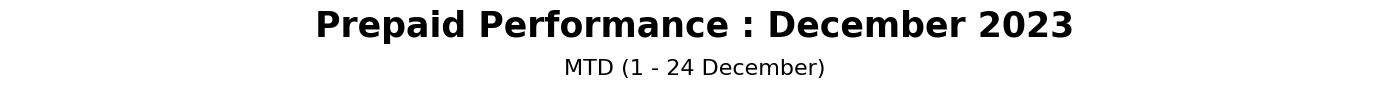

In [24]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

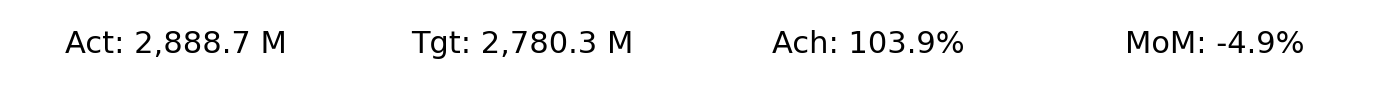

In [25]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(mtd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

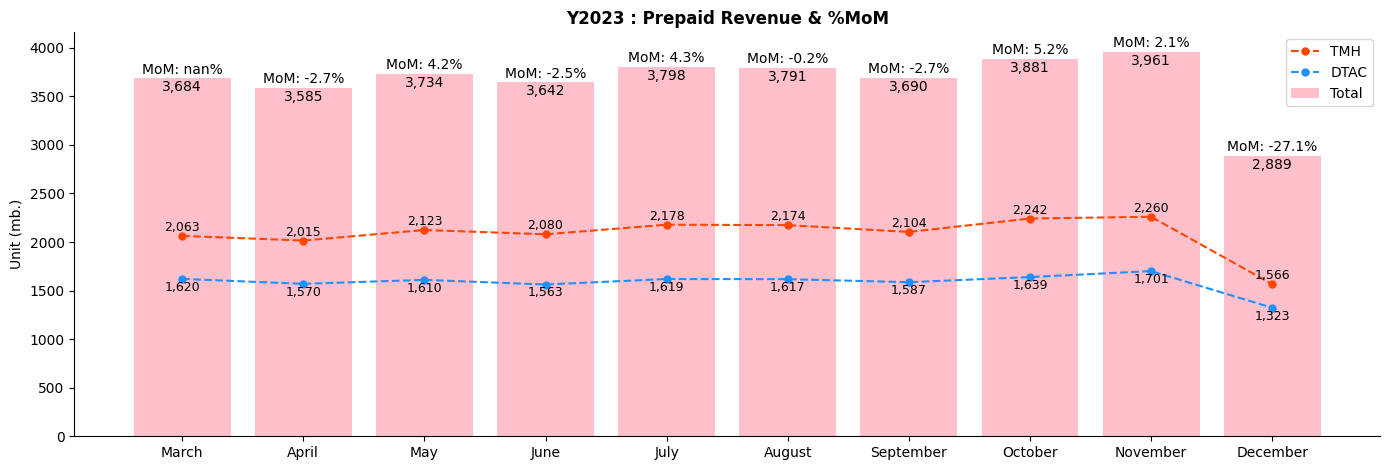

In [26]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : {v_product} Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')
plt.plot(x_mth_axis, unit_mb(y_mth_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, unit_mb(y_mth_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+20), ha='center', va='bottom')
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])-20), ha='center', va='top')
    # plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_tmh[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])+20), ha='center', va='bottom', fontsize=9)
    # plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_dtac[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])-20), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

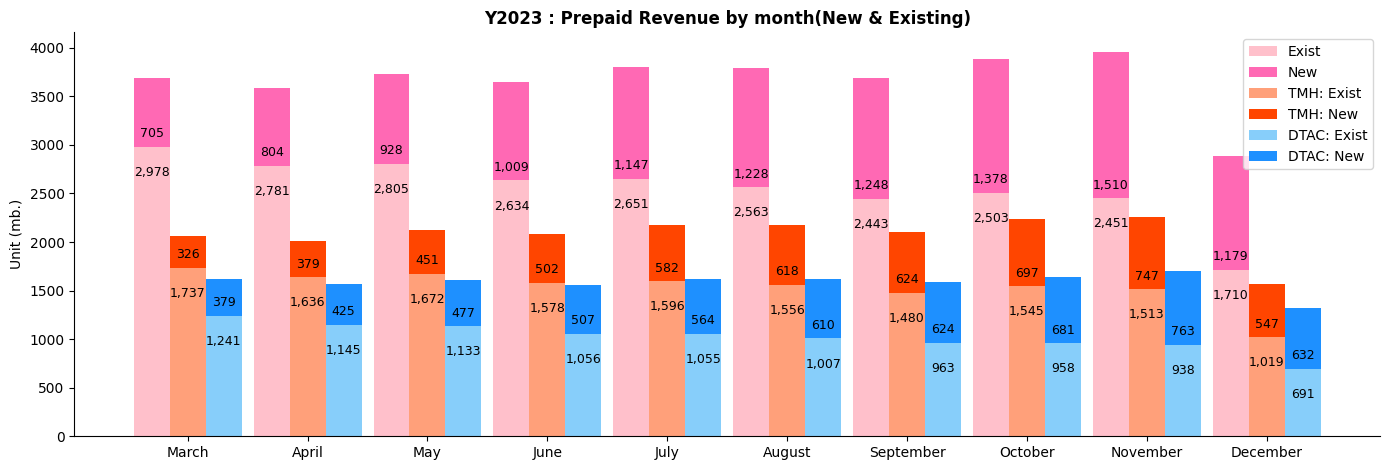

In [27]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3

plt.title(f'Y{curr_yr} : {v_product} Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_mth_axis-diff_loc, unit_mb(y_mth_act_exist), width, label='Exist', color='pink')
plt.bar(x_mth_axis-diff_loc, unit_mb(y_mth_act_new), width, label='New', color='hotpink', bottom=unit_mb(y_mth_act_exist))
plt.bar(x_mth_axis, unit_mb(y_mth_act_exist_tmh), width, label='TMH: Exist', color='lightsalmon')
plt.bar(x_mth_axis, unit_mb(y_mth_act_new_tmh), width, label='TMH: New', color='orangered', bottom=unit_mb(y_mth_act_exist_tmh))
plt.bar(x_mth_axis+diff_loc, unit_mb(y_mth_act_exist_dtac), width, label='DTAC: Exist', color='lightskyblue')
plt.bar(x_mth_axis+diff_loc, unit_mb(y_mth_act_new_dtac), width, label='DTAC: New', color='dodgerblue', bottom=unit_mb(y_mth_act_exist_dtac))
for i in x_mth_axis:    
    plt.annotate(format(unit_mb(y_mth_act_exist[i]),',.0f'), xy=(x_mth_axis[i]-diff_loc, unit_mb(y_mth_act_exist[i])-300), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new[i]),',.0f'), xy=(x_mth_axis[i]-diff_loc, unit_mb(y_mth_act_exist[i])+100), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_tmh[i])-300), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_tmh[i])+100), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist_dtac[i]),',.0f'), xy=(x_mth_axis[i]+diff_loc, unit_mb(y_mth_act_exist_dtac[i])-300), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new_dtac[i]),',.0f'), xy=(x_mth_axis[i]+diff_loc, unit_mb(y_mth_act_exist_dtac[i])+100), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

#### MTH : Prepaid Revenue : TMH vs DTAC

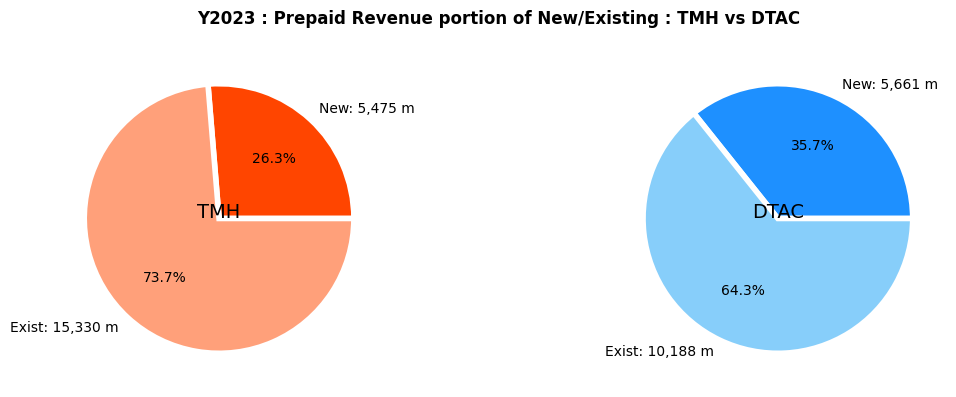

In [28]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([unit_mb(sum(y_mth_act_new_tmh)), unit_mb(sum(y_mth_act_exist_tmh))])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'TMH', ha='center', fontsize=14)

''' ax2 '''
y = np.array([unit_mb(sum(y_mth_act_new_dtac)), unit_mb(sum(y_mth_act_exist_dtac))])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'DTAC', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

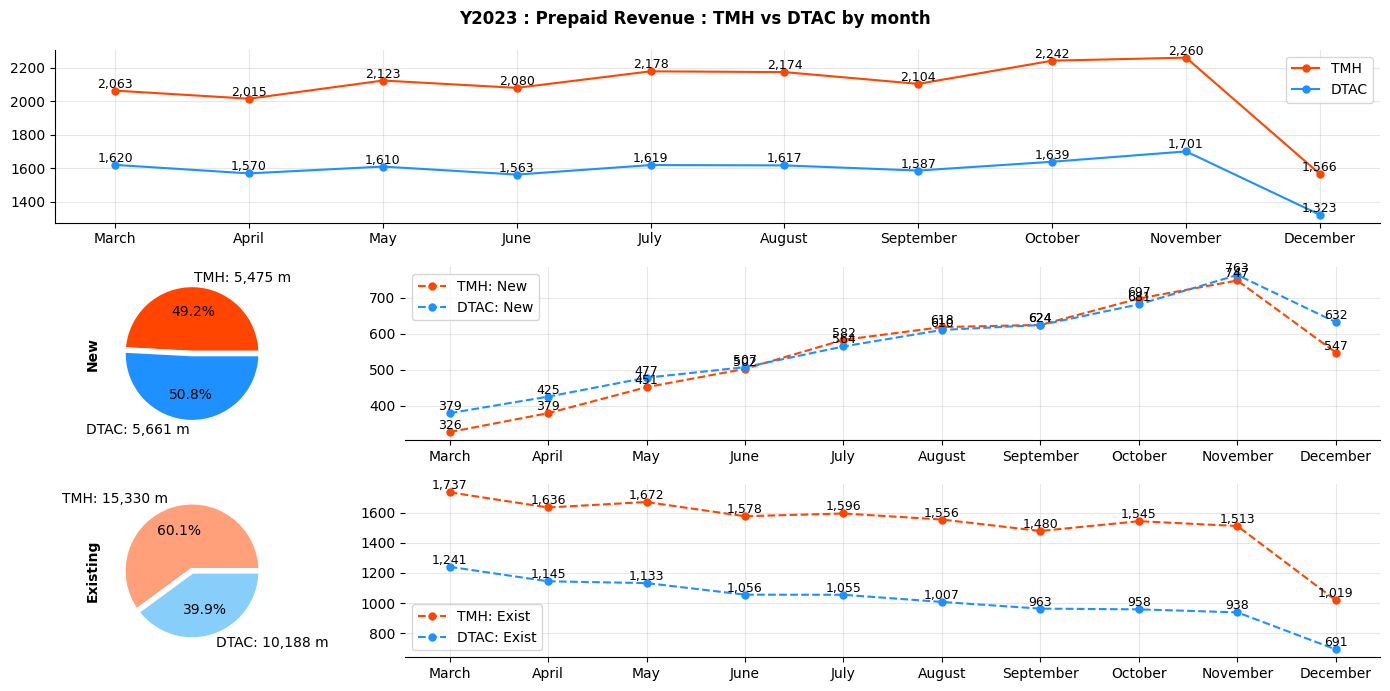

In [29]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([unit_mb(sum(y_mth_act_new_tmh)), unit_mb(sum(y_mth_act_new_dtac))])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([unit_mb(sum(y_mth_act_exist_tmh)), unit_mb(sum(y_mth_act_exist_dtac))])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_mth_axis, unit_mb(y_mth_act_tmh), marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_mth_axis, unit_mb(y_mth_act_dtac), marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_mth_axis, x_mth)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_mth_axis:
    ax3.annotate(format(unit_mb(y_mth_act_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(unit_mb(y_mth_act_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])), ha='center', va='bottom', fontsize=9)

''' ax4 '''
ax4.plot(x_mth_axis, unit_mb(y_mth_act_new_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: New', color='orangered')
ax4.plot(x_mth_axis, unit_mb(y_mth_act_new_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_mth_axis, x_mth)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax4.annotate(format(unit_mb(y_mth_act_new_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new_tmh[i])), ha='center', va='bottom', fontsize=9)
    ax4.annotate(format(unit_mb(y_mth_act_new_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new_dtac[i])), ha='center', va='bottom', fontsize=9)

''' ax5 '''
ax5.plot(x_mth_axis, unit_mb(y_mth_act_exist_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: Exist', color='orangered')
ax5.plot(x_mth_axis, unit_mb(y_mth_act_exist_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_mth_axis, x_mth)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax5.annotate(format(unit_mb(y_mth_act_exist_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_tmh[i])), ha='center', va='bottom', fontsize=9)
    ax5.annotate(format(unit_mb(y_mth_act_exist_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_dtac[i])), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

#### MTH : Prepaid Performance : %Achievement & Gap

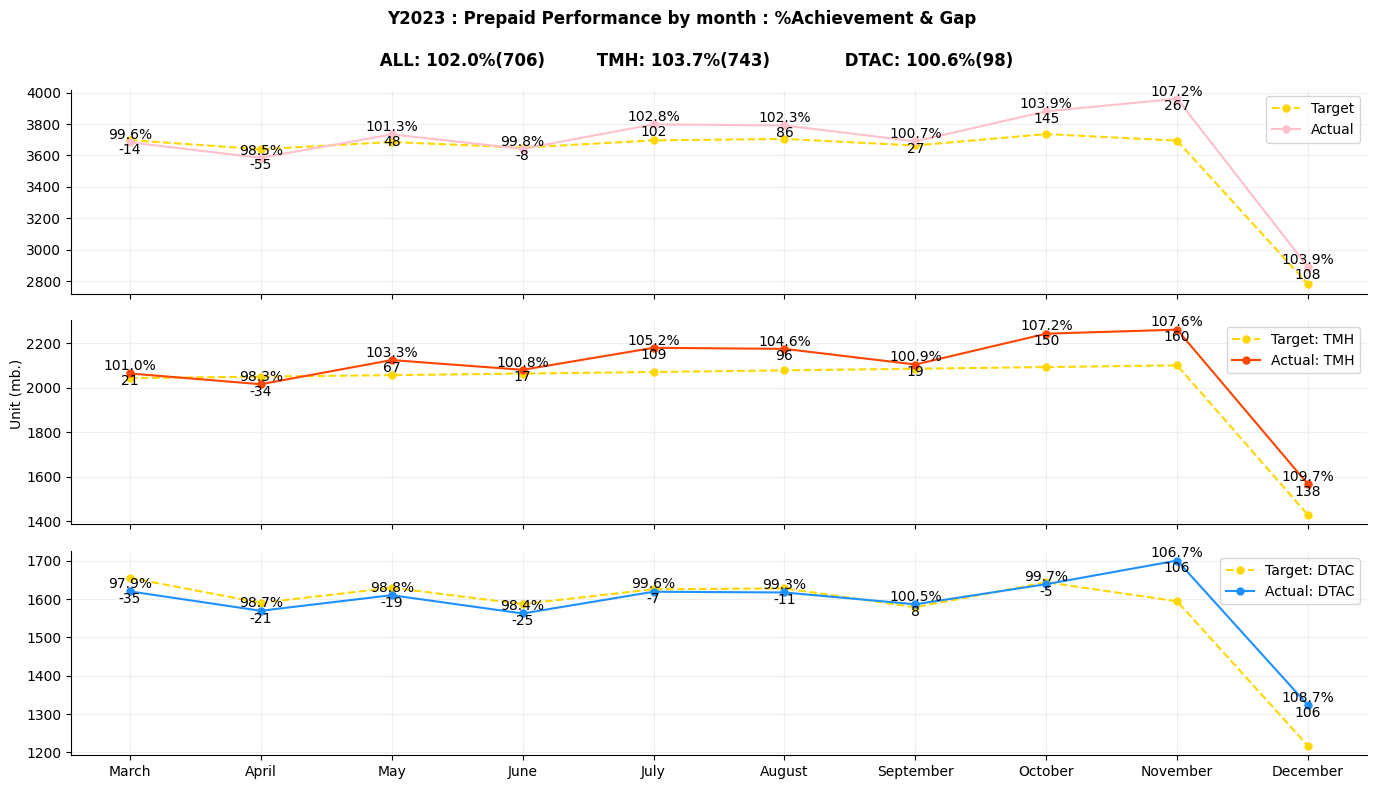

In [30]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} : {v_product} Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(unit_mb(sum(y_mth_gap)),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(unit_mb(sum(y_mth_gap_tmh)),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(unit_mb(sum(y_mth_gap_dtac)),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, unit_mb(y_mth_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+1), ha='center', va='bottom')
    ax1.annotate(format(unit_mb(y_mth_gap[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, unit_mb(y_mth_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, unit_mb(y_mth_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])+1), ha='center', va='bottom')
    ax2.annotate(format(unit_mb(y_mth_gap_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, unit_mb(y_mth_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, unit_mb(y_mth_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])+1), ha='center', va='bottom')
    ax3.annotate(format(unit_mb(y_mth_gap_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

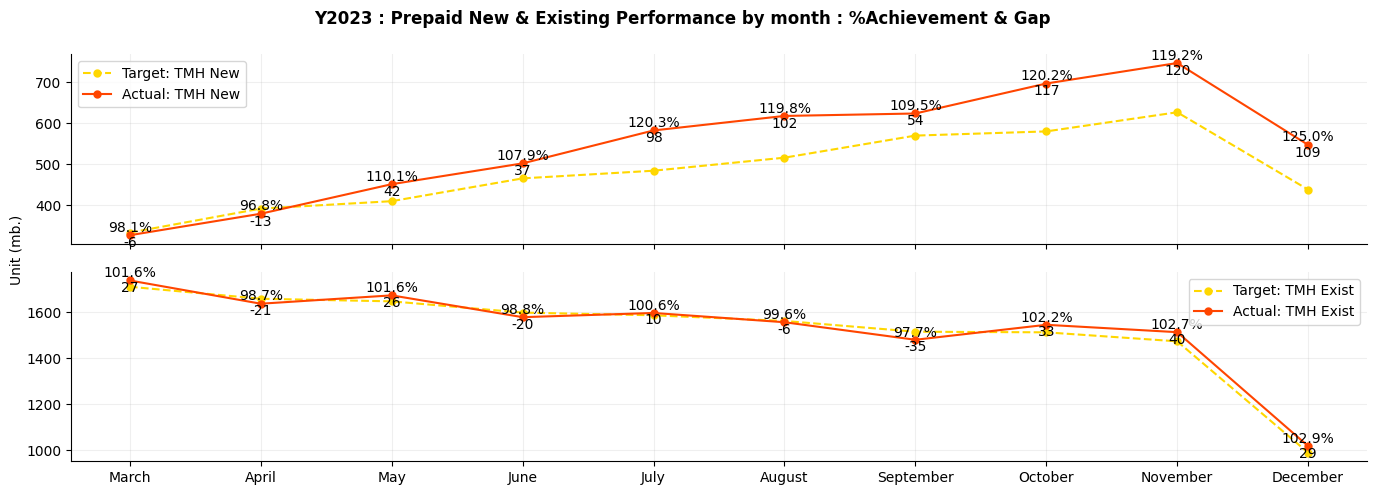

In [31]:
''' TMH : New & Existing : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 5))
fig.suptitle(f'Y{curr_yr} : {v_product} New & Existing Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, unit_mb(y_mth_tgt_new_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH New', color='gold')
ax1.plot(x_mth_axis, unit_mb(y_mth_act_new_tmh), marker='.', markeredgewidth=3, label='Actual: TMH New', color='orangered')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_new_tmh[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new_tmh[i])+1), ha='center', va='bottom')
    ax1.annotate(format(unit_mb(y_mth_gap_new_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new_tmh[i])-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, unit_mb(y_mth_tgt_exist_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH Exist', color='gold')
ax2.plot(x_mth_axis, unit_mb(y_mth_act_exist_tmh), marker='.', markeredgewidth=3, label='Actual: TMH Exist', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_exist_tmh[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_tmh[i])+1), ha='center', va='bottom')
    ax2.annotate(format(unit_mb(y_mth_gap_exist_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist_tmh[i])-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly **

### WK : Aggregation

In [32]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_wk['%ACHV'] = np.where(df_wk['METRIC_NAME'].str.contains("Churn"), -((df_wk['ACT']/df_wk['TGT'])-1), df_wk['ACT']/df_wk['TGT']) 
df_wk['GAP'] = df_wk['ACT'] - df_wk['TGT']
df_wk['LAST_ACT'] = df_wk.groupby('METRIC_CD')['ACT'].shift()
df_wk['DIFF'] = df_wk['ACT'] - df_wk['LAST_ACT']
df_wk['%WOW'] = (df_wk['ACT'] / df_wk['LAST_ACT']) - 1

# df_wk.to_excel('df_wk.xlsx')
df_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
384,TB1R000102CORP,Prepaid Existing Revenue : TMH,2023049,49,S,3.439476e+08,3.299262e+08,1.042499,1.402137e+07,4.001623e+08,-5.621472e+07,-0.140480
385,TB1R000102CORP,Prepaid Existing Revenue : TMH,2023050,50,S,3.225721e+08,3.299262e+08,0.977710,-7.354077e+06,3.439476e+08,-2.137545e+07,-0.062147
386,TB1R000102CORP,Prepaid Existing Revenue : TMH,2023051,51,S,1.823972e+08,1.885292e+08,0.967474,-6.132090e+06,3.225721e+08,-1.401749e+08,-0.434554


In [33]:
''' Pivot by KPIS '''

df_wk_agg = df_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_wk_agg.tail(3)

TM_KEY_WK WK_LABEL           ACT                              \
METRIC_NAME                            EXIST    EXIST_DTAC     EXIST_TMH   
40            2023049       49  5.620710e+08  2.181235e+08  3.439476e+08   
41            2023050       50  5.172053e+08  1.946332e+08  3.225721e+08   
42            2023051       51  3.504525e+08  1.680554e+08  1.823972e+08   

                                                                     \
METRIC_NAME           NEW      NEW_DTAC       NEW_TMH         TOTAL   
40           3.807042e+08  1.961477e+08  1.845565e+08  9.427753e+08   
41           3.585942e+08  1.831338e+08  1.754604e+08  8.757995e+08   
42           2.631613e+08  1.608337e+08  1.023276e+08  6.136138e+08   

                           ...          DIFF      %WOW                       \
METRIC_NAME    TOTAL_DTAC  ...     TOTAL_TMH     EXIST EXIST_DTAC EXIST_TMH   
40           4.142712e+08  ... -6.923110e+07 -0.136396  -0.129877 -0.140480   
41           3.777670e+08  ... -3.047154e+07 -0.079822  -0.107693 -0.062147   
42           3.288890e+08  ... -2.133077e+08 -0.322411  -0.136553 -0.434554   

                                                                          
METRIC_NAME       NEW  NEW_DTAC   NEW_TMH     TOTAL TOTAL_DTAC TOTAL_TMH  
40          -0.021791  0.023671 -0.065881 -0.093510  -0.063357 -0.115822  
41          -0.058077 -0.066348 -0.049286 -0.071041  -0.088117 -0.057656  
42          -0.266131 -0.121770 -0.416805 -0.299367  -0.129386 -0.428301  

[3 rows x 65 columns]

In [34]:
''' WTD Values '''

df_last_wk = df_day_agg[df_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT', 'TGT']]
day_cnt_curr_wk = len(df_day_agg[(df_day_agg['TM_KEY_WK']==curr_wk) & (df_day_agg['ACT']['TOTAL']>0)]['TM_KEY_DAY'].unique())

wtd_last_act = (df_last_wk['ACT']['TOTAL'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['ACT']['TOTAL'].sum()
wtd_tgt = df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['TGT']['TOTAL'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [35]:
''' Week Chart Values '''

x_wk = df_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_wk_agg['ACT']['TOTAL']
y_wk_act_dtac = df_wk_agg['ACT']['TOTAL_DTAC']
y_wk_act_tmh = df_wk_agg['ACT']['TOTAL_TMH']
y_wk_tgt = df_wk_agg['TGT']['TOTAL']
y_wk_tgt_dtac = df_wk_agg['TGT']['TOTAL_DTAC']
y_wk_tgt_tmh = df_wk_agg['TGT']['TOTAL_TMH']
y_wk_achv = df_wk_agg['%ACHV']['TOTAL']
y_wk_achv_dtac = df_wk_agg['%ACHV']['TOTAL_DTAC']
y_wk_achv_tmh = df_wk_agg['%ACHV']['TOTAL_TMH']
y_wk_gap = df_wk_agg['GAP']['TOTAL']
y_wk_gap_dtac = df_wk_agg['GAP']['TOTAL_DTAC']
y_wk_gap_tmh = df_wk_agg['GAP']['TOTAL_TMH']
y_wk_diff = df_wk_agg['DIFF']['TOTAL']
y_wk_diff_dtac = df_wk_agg['DIFF']['TOTAL_DTAC']
y_wk_diff_tmh = df_wk_agg['DIFF']['TOTAL_TMH']
y_wk_last_act = df_wk_agg['LAST_ACT']['TOTAL']
y_wk_last_act_dtac = df_wk_agg['LAST_ACT']['TOTAL_DTAC']
y_wk_last_act_tmh = df_wk_agg['LAST_ACT']['TOTAL_TMH']
y_wk_wow = df_wk_agg['%WOW']['TOTAL']
y_wk_wow_dtac = df_wk_agg['%WOW']['TOTAL_DTAC']
y_wk_wow_tmh = df_wk_agg['%WOW']['TOTAL_TMH']

''' NEW : Values '''
y_wk_act_new = df_wk_agg['ACT']['NEW']
y_wk_act_new_dtac = df_wk_agg['ACT']['NEW_DTAC']
y_wk_act_new_tmh = df_wk_agg['ACT']['NEW_TMH']
y_wk_tgt_new = df_wk_agg['TGT']['NEW']
y_wk_tgt_new_dtac = df_wk_agg['TGT']['NEW_DTAC']
y_wk_tgt_new_tmh = df_wk_agg['TGT']['NEW_TMH']
y_wk_achv_new = df_wk_agg['%ACHV']['NEW']
y_wk_achv_new_dtac = df_wk_agg['%ACHV']['NEW_DTAC']
y_wk_achv_new_tmh = df_wk_agg['%ACHV']['NEW_TMH']
y_wk_gap_new = df_wk_agg['GAP']['NEW']
y_wk_gap_new_dtac = df_wk_agg['GAP']['NEW_DTAC']
y_wk_gap_new_tmh = df_wk_agg['GAP']['NEW_TMH']
y_wk_diff_new = df_wk_agg['DIFF']['NEW']
y_wk_diff_new_dtac = df_wk_agg['DIFF']['NEW_DTAC']
y_wk_diff_new_tmh = df_wk_agg['DIFF']['NEW_TMH']
y_wk_last_act_new = df_wk_agg['LAST_ACT']['NEW']
y_wk_last_act_new_dtac = df_wk_agg['LAST_ACT']['NEW_DTAC']
y_wk_last_act_new_tmh = df_wk_agg['LAST_ACT']['NEW_TMH']
y_wk_wow_new = df_wk_agg['%WOW']['NEW']
y_wk_wow_new_dtac = df_wk_agg['%WOW']['NEW_DTAC']
y_wk_wow_new_tmh = df_wk_agg['%WOW']['NEW_TMH']

''' EXIST : Values '''
y_wk_act_exist = df_wk_agg['ACT']['EXIST']
y_wk_act_exist_dtac = df_wk_agg['ACT']['EXIST_DTAC']
y_wk_act_exist_tmh = df_wk_agg['ACT']['EXIST_TMH']
y_wk_tgt_exist = df_wk_agg['TGT']['EXIST']
y_wk_tgt_exist_dtac = df_wk_agg['TGT']['EXIST_DTAC']
y_wk_tgt_exist_tmh = df_wk_agg['TGT']['EXIST_TMH']
y_wk_achv_exist = df_wk_agg['%ACHV']['EXIST']
y_wk_achv_exist_dtac = df_wk_agg['%ACHV']['EXIST_DTAC']
y_wk_achv_exist_tmh = df_wk_agg['%ACHV']['EXIST_TMH']
y_wk_gap_exist = df_wk_agg['GAP']['EXIST']
y_wk_gap_exist_dtac = df_wk_agg['GAP']['EXIST_DTAC']
y_wk_gap_exist_tmh = df_wk_agg['GAP']['EXIST_TMH']
y_wk_diff_exist = df_wk_agg['DIFF']['EXIST']
y_wk_diff_exist_dtac = df_wk_agg['DIFF']['EXIST_DTAC']
y_wk_diff_exist_tmh = df_wk_agg['DIFF']['EXIST_TMH']
y_wk_last_act_exist = df_wk_agg['LAST_ACT']['EXIST']
y_wk_last_act_exist_dtac = df_wk_agg['LAST_ACT']['EXIST_DTAC']
y_wk_last_act_exist_tmh = df_wk_agg['LAST_ACT']['EXIST_TMH']
y_wk_wow_exist = df_wk_agg['%WOW']['EXIST']
y_wk_wow_exist_dtac = df_wk_agg['%WOW']['EXIST_DTAC']
y_wk_wow_exist_tmh = df_wk_agg['%WOW']['EXIST_TMH']

### WK : Visualizations

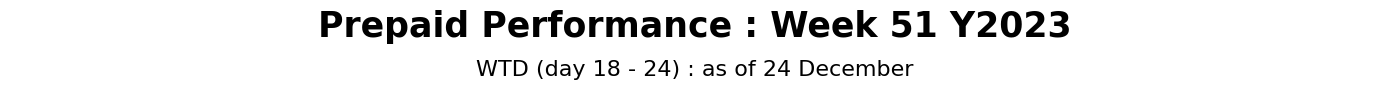

In [36]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

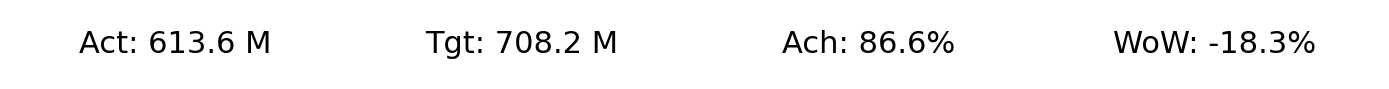

In [37]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(wtd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

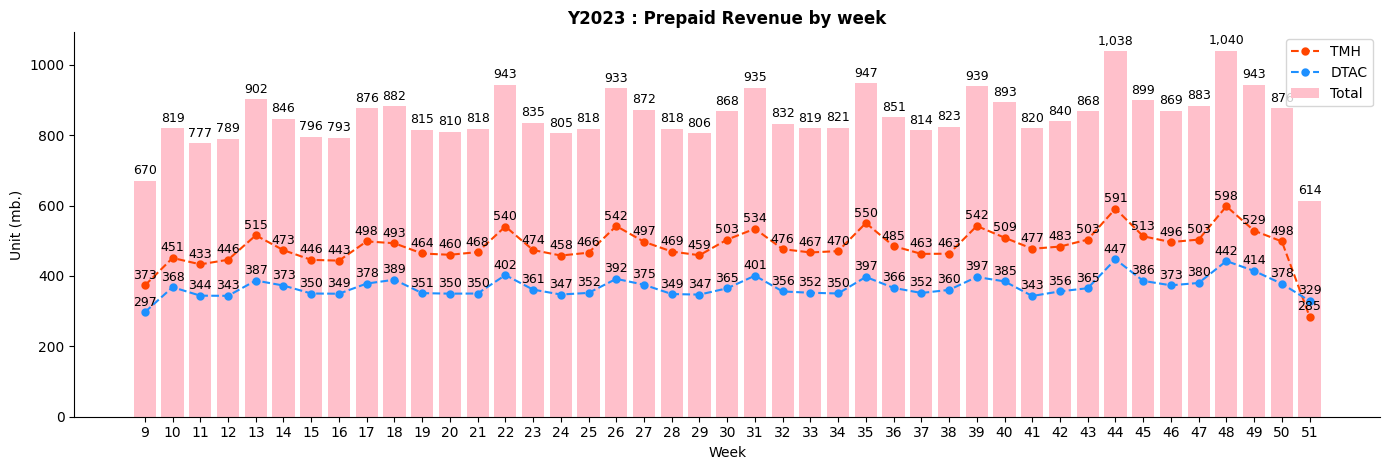

In [38]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : {v_product} Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_tmh[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_dtac[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])+10), ha='center', va='bottom', fontsize=9)
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

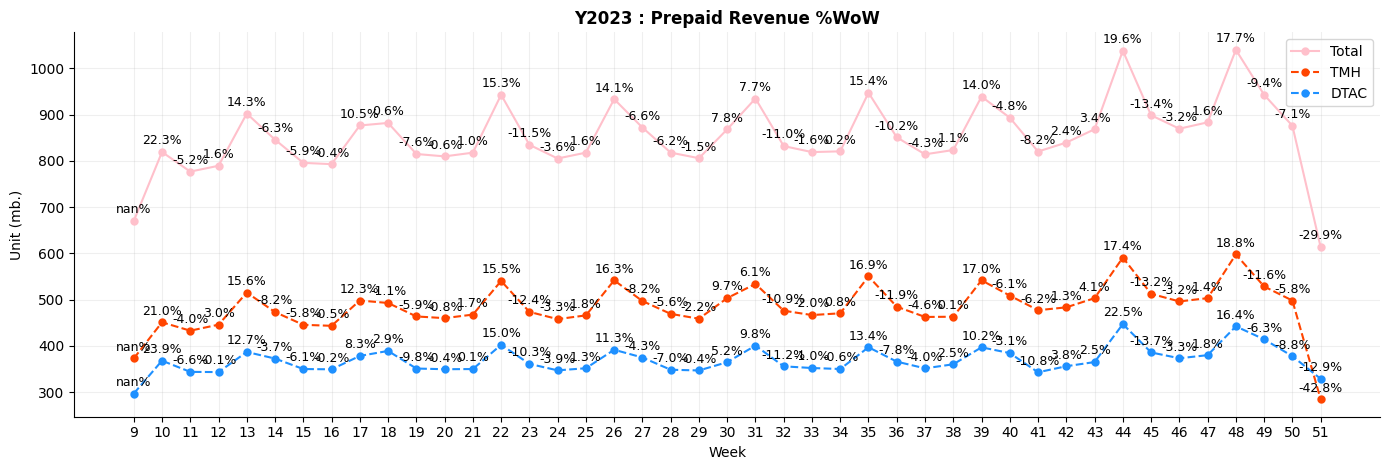

In [39]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : {v_product} Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, unit_mb(y_wk_act), marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])+10), ha='center', va='bottom', fontsize=9)
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

#### WK : Prepaid Performance : %Achievement & Gap

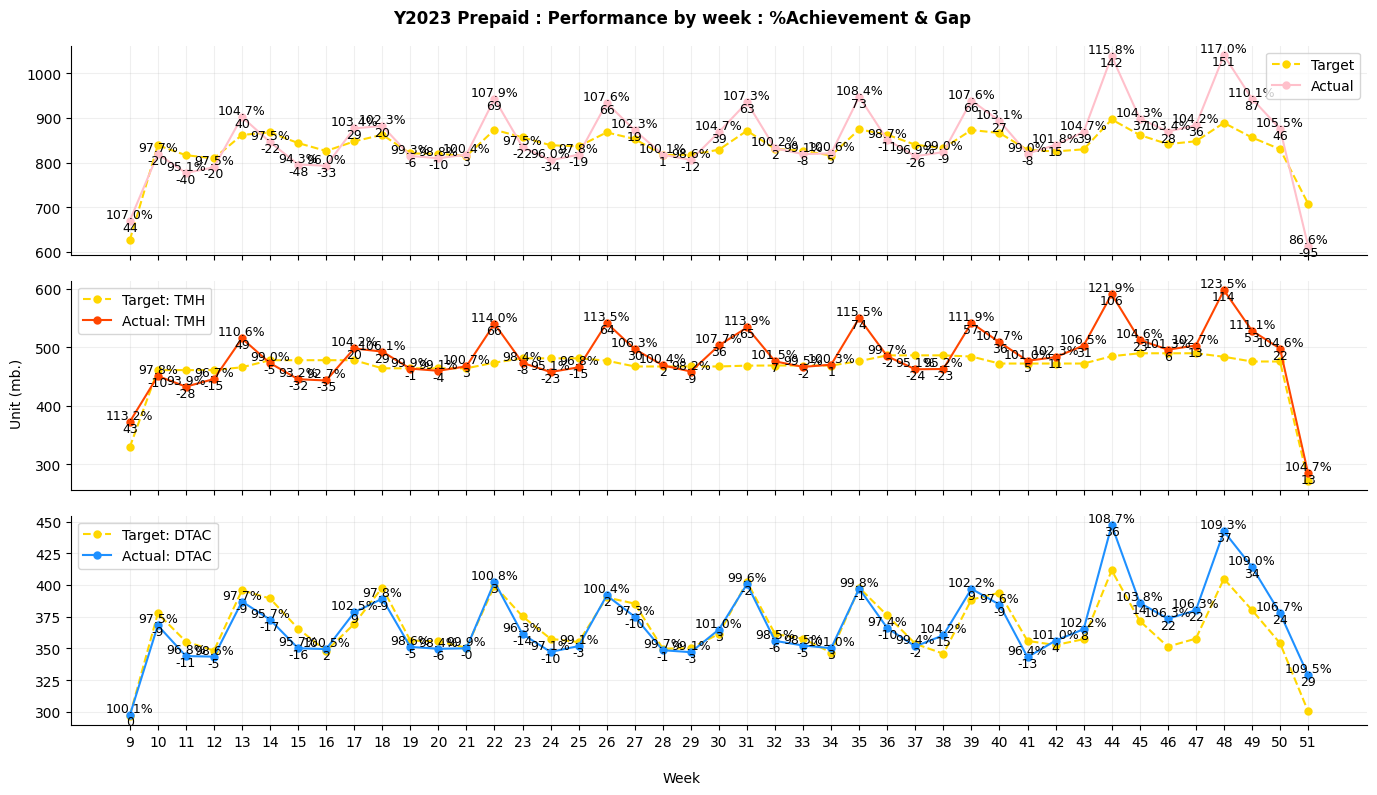

In [40]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} {v_product} : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, unit_mb(y_wk_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(unit_mb(y_wk_gap[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, unit_mb(y_wk_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(unit_mb(y_wk_gap_tmh[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, unit_mb(y_wk_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(unit_mb(y_wk_gap_dtac[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [41]:
''' Create Dataframe '''

df_day_curr_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_day_last_mth = df_day_agg[(df_day_agg['TM_KEY_MTH']==last_mth) & (df_day_agg['DAY_LABEL'].isin(df_day_curr_mth['DAY_LABEL']))][['TM_KEY_DAY', 'DAY_LABEL', 'ACT']].reset_index()

df_day_curr_mth_clean = df_day_curr_mth[df_day_curr_mth['ACT']['TOTAL'] > 0].reset_index()

df_day_curr_day = df_day_curr_mth_clean.loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_day_last_day = df_day_curr_mth_clean.shift().loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [42]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_day_last_day['ACT']['TOTAL'].sum()
last_day_rev_new = df_day_last_day['ACT']['NEW'].sum()
last_day_rev_exist = df_day_last_day['ACT']['EXIST'].sum()

''' TOTAL : Values '''
dtd_rev = df_day_curr_day['ACT']['TOTAL'].sum()
dtd_tgt = df_day_curr_day['TGT']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_day_last_day['ACT']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_day_curr_day['ACT']['NEW'].sum()
dtd_tgt_new = df_day_curr_day['TGT']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_day_last_day['ACT']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_day_curr_day['ACT']['EXIST'].sum()
dtd_tgt_exist = df_day_curr_day['TGT']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_day_last_day['ACT']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

In [43]:
''' Day Chart Values '''

x_day = df_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_day_curr_mth['ACT']['TOTAL']
y_day_act_dtac = df_day_curr_mth['ACT']['TOTAL_DTAC']
y_day_act_tmh = df_day_curr_mth['ACT']['TOTAL_TMH']
y_day_tgt = df_day_curr_mth['TGT']['TOTAL']
y_day_tgt_dtac = df_day_curr_mth['TGT']['TOTAL_DTAC']
y_day_tgt_tmh = df_day_curr_mth['TGT']['TOTAL_TMH']
y_day_achv = df_day_curr_mth['%ACHV']['TOTAL']
y_day_achv_dtac = df_day_curr_mth['%ACHV']['TOTAL_DTAC']
y_day_achv_tmh = df_day_curr_mth['%ACHV']['TOTAL_TMH']
y_day_gap = df_day_curr_mth['GAP']['TOTAL']
y_day_gap_dtac = df_day_curr_mth['GAP']['TOTAL_DTAC']
y_day_gap_tmh = df_day_curr_mth['GAP']['TOTAL_TMH']
y_day_diff = df_day_curr_mth['DIFF']['TOTAL']
y_day_diff_dtac = df_day_curr_mth['DIFF']['TOTAL_DTAC']
y_day_diff_tmh = df_day_curr_mth['DIFF']['TOTAL_TMH']
# y_day_last_act = df_day_curr_mth['LAST_ACT']['TOTAL']
# y_day_last_act_dtac = df_day_curr_mth['LAST_ACT']['TOTAL_DTAC']
# y_day_last_act_tmh = df_day_curr_mth['LAST_ACT']['TOTAL_TMH']
y_day_last_act = df_day_last_mth['ACT']['TOTAL']
y_day_last_act_dtac = df_day_last_mth['ACT']['TOTAL_DTAC']
y_day_last_act_tmh = df_day_last_mth['ACT']['TOTAL_TMH']
y_day_dod = df_day_curr_mth['%DOD']['TOTAL']
y_day_dod_dtac = df_day_curr_mth['%DOD']['TOTAL_DTAC']
y_day_dod_tmh = df_day_curr_mth['%DOD']['TOTAL_TMH']

''' NEW : Values '''
y_day_act_new = df_day_curr_mth['ACT']['NEW']
y_day_act_new_dtac = df_day_curr_mth['ACT']['NEW_DTAC']
y_day_act_new_tmh = df_day_curr_mth['ACT']['NEW_TMH']
y_day_tgt_new = df_day_curr_mth['TGT']['NEW']
y_day_tgt_new_dtac = df_day_curr_mth['TGT']['NEW_DTAC']
y_day_tgt_new_tmh = df_day_curr_mth['TGT']['NEW_TMH']
y_day_achv_new = df_day_curr_mth['%ACHV']['NEW']
y_day_achv_new_dtac = df_day_curr_mth['%ACHV']['NEW_DTAC']
y_day_achv_new_tmh = df_day_curr_mth['%ACHV']['NEW_TMH']
y_day_gap_new = df_day_curr_mth['GAP']['NEW']
y_day_gap_new_dtac = df_day_curr_mth['GAP']['NEW_DTAC']
y_day_gap_new_tmh = df_day_curr_mth['GAP']['NEW_TMH']
y_day_diff_new = df_day_curr_mth['DIFF']['NEW']
y_day_diff_new_dtac = df_day_curr_mth['DIFF']['NEW_DTAC']
y_day_diff_new_tmh = df_day_curr_mth['DIFF']['NEW_TMH']
y_day_last_act_new = df_day_last_mth['ACT']['NEW']
y_day_last_act_new_dtac = df_day_last_mth['ACT']['NEW_DTAC']
y_day_last_act_new_tmh = df_day_last_mth['ACT']['NEW_TMH']
y_day_dod_new = df_day_curr_mth['%DOD']['NEW']
y_day_dod_new_dtac = df_day_curr_mth['%DOD']['NEW_DTAC']
y_day_dod_new_tmh = df_day_curr_mth['%DOD']['NEW_TMH']

''' EXIST : Values '''
y_day_act_exist = df_day_curr_mth['ACT']['EXIST']
y_day_act_exist_dtac = df_day_curr_mth['ACT']['EXIST_DTAC']
y_day_act_exist_tmh = df_day_curr_mth['ACT']['EXIST_TMH']
y_day_tgt_exist = df_day_curr_mth['TGT']['EXIST']
y_day_tgt_exist_dtac = df_day_curr_mth['TGT']['EXIST_DTAC']
y_day_tgt_exist_tmh = df_day_curr_mth['TGT']['EXIST_TMH']
y_day_achv_exist = df_day_curr_mth['%ACHV']['EXIST']
y_day_achv_exist_dtac = df_day_curr_mth['%ACHV']['EXIST_DTAC']
y_day_achv_exist_tmh = df_day_curr_mth['%ACHV']['EXIST_TMH']
y_day_gap_exist = df_day_curr_mth['GAP']['EXIST']
y_day_gap_exist_dtac = df_day_curr_mth['GAP']['EXIST_DTAC']
y_day_gap_exist_tmh = df_day_curr_mth['GAP']['EXIST_TMH']
y_day_diff_exist = df_day_curr_mth['DIFF']['EXIST']
y_day_diff_exist_dtac = df_day_curr_mth['DIFF']['EXIST_DTAC']
y_day_diff_exist_tmh = df_day_curr_mth['DIFF']['EXIST_TMH']
y_day_last_act_exist = df_day_last_mth['ACT']['EXIST']
y_day_last_act_exist_dtac = df_day_last_mth['ACT']['EXIST_DTAC']
y_day_last_act_exist_tmh = df_day_last_mth['ACT']['EXIST_TMH']
y_day_dod_exist = df_day_curr_mth['%DOD']['EXIST']
y_day_dod_exist_dtac = df_day_curr_mth['%DOD']['EXIST_DTAC']
y_day_dod_exist_tmh = df_day_curr_mth['%DOD']['EXIST_TMH']

### DAY : Visualizations

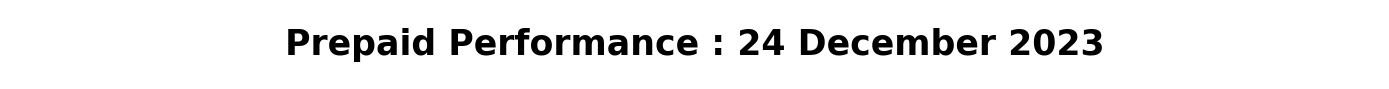

In [44]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

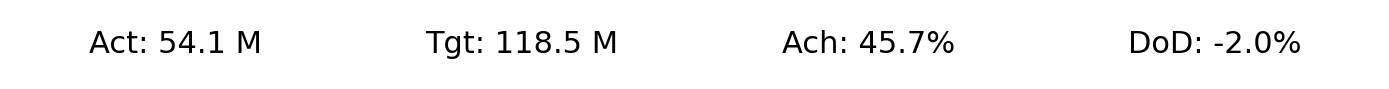

In [45]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

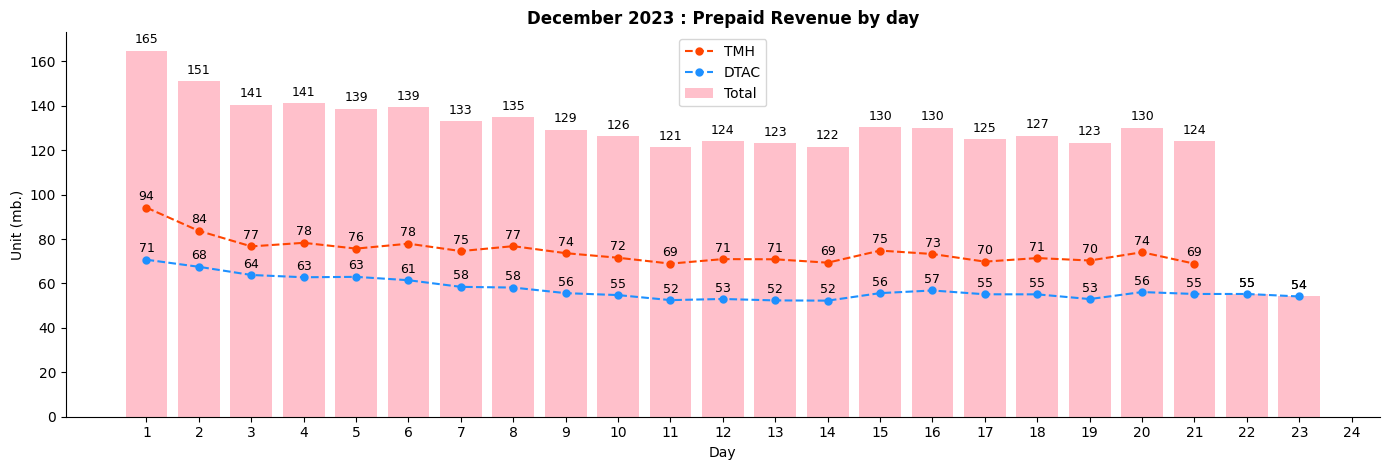

In [46]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_tmh[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_dtac[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

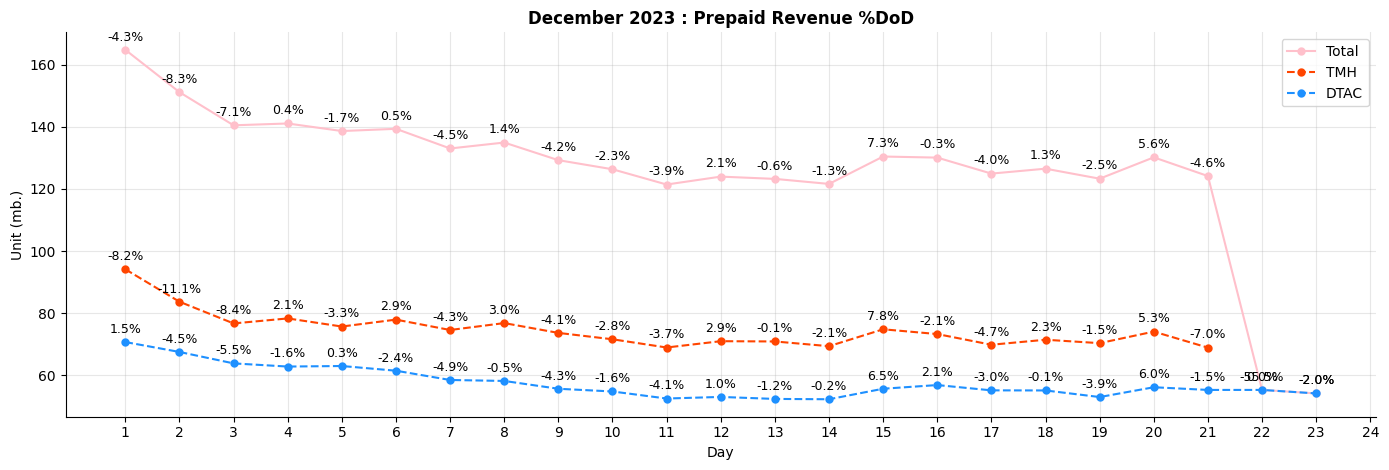

In [47]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, unit_mb(y_day_act), marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+2), ha='center', va='bottom', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### DAY : Prepaid Performance : %Achievement & Gap

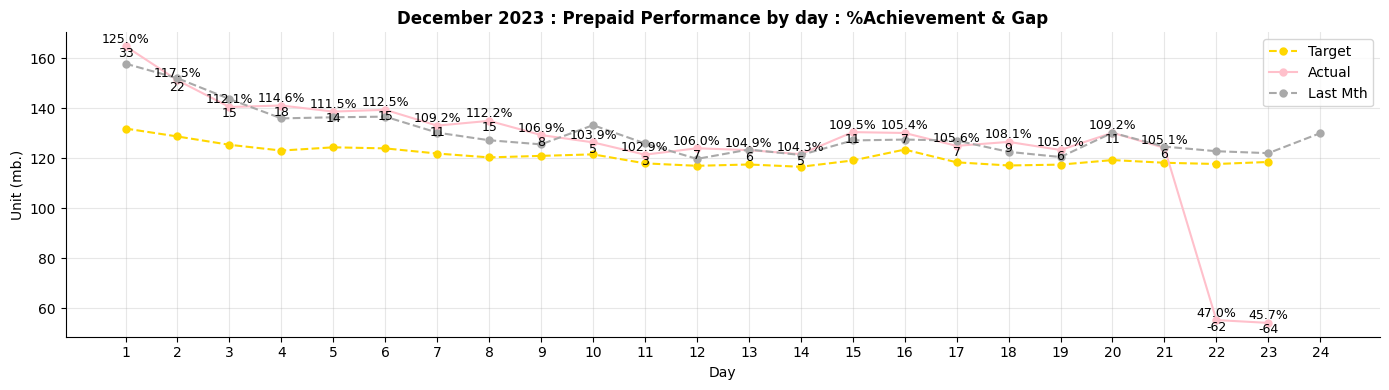

In [48]:
''' Peformance : %Achievement & Gap : Day Chart '''

plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_last_act), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_gap[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])-0.2), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

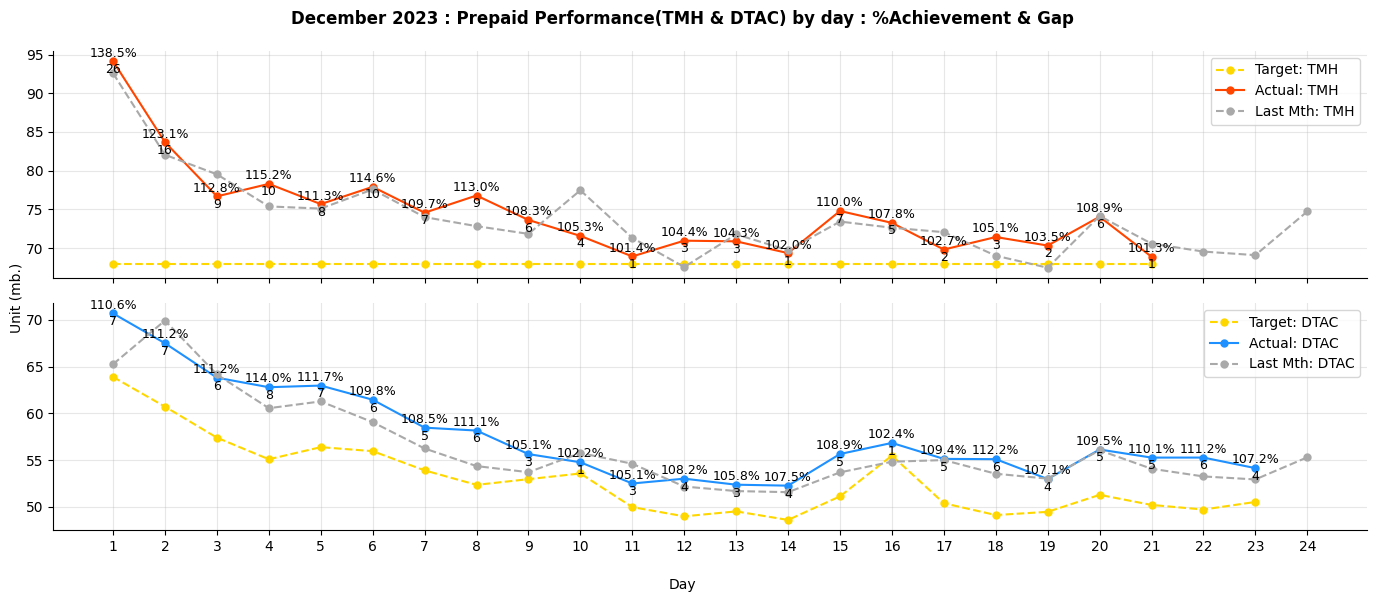

In [49]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : {v_product} Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, unit_mb(y_day_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, unit_mb(y_day_last_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(unit_mb(y_day_gap_tmh[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, unit_mb(y_day_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, unit_mb(y_day_last_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(unit_mb(y_day_gap_dtac[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel('Day', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()